# Amazon Reviews - Prediction of Rating and Helpfulness (an NLP Use Case)
## Exploratory Data Analysis (EDA)

In this notebook, I have explored the Amazon Review Dataset.

## Table of Contents
* [Load Data](#ld)
* [Rating Exploration](#re)
  * [Rating Distribution](#rd)
  * [Number of Reviews for Different Product Categories](#rpc)
  * [Number of Reviews over Years](#roy)
  * [Average Rating of Different Product Categories](#arpc)  
  * [Average Rating over Years](#ary)  
  * [Top 10 Products with Most Reviews](#pmr)  
  * [Top 10 most Prolific Reviewers](#tpr)  
* [Helpfulness Exploration](#he)  
  * [Distribution of Total Votes](#dtv)  
  * [Top 5 Reviews with Highest Total Votes](#tht)
  * [Top 5 Reviews with Highest Helpful Votes](#thh)
  * [Top 10 Reviewers with Most Helpful Votes](#thv)
  * [Average Helpfull Votes Vs Star Rating](#ahsr)
  * [Average Total Votes Vs Star Rating](#atsr)
  * [Average helpful_index Vs Star Rating](#ahi)
  * [Average Total Votes over Years](#atvy)
  * [Average Helpful Votes over Years](#ahvy)
  * [Average Helpful Index over Years](#ahiy)
* [Findings of EDA](#eda)

#### Setting up PySpark and Accessing S3 Bucket

In [5]:
# If you are running this notebook outside of AWS EMR, please uncomment the following lines and run
# from pyspark.context import SparkContext
# from pyspark.sql.context import SQLContext
# from pyspark.sql.session import SparkSession

# sc = SparkContext()
# sqlContext = SQLContext(sc)
# spark = SparkSession(sc)

In [6]:
# # Replace the content inside <> with your S3 credentials
# ACCESS_KEY = "<aws-access-key>"
# SECRET_KEY = "<aws-secret-key>"
# ENCODED_SECRET_KEY = SECRET_KEY.replace("/", "%2F")
# AWS_BUCKET_NAME = "amazon-reviews-pds"
# MOUNT_NAME = "mount_1"

# dbutils.fs.mount("s3a://%s:%s@%s" % (ACCESS_KEY, ENCODED_SECRET_KEY, AWS_BUCKET_NAME), "/mnt/%s" % MOUNT_NAME)
# display(dbutils.fs.ls("/mnt/%s" % MOUNT_NAME))

In [7]:
sqlContext

Out[ 1 ]: <pyspark.sql.context.HiveContext at 0x7f5f4c2613c8>

<a id='ld'></a>
## Load Data
Amazon review dataset is spread across 46 tsv files in amazon S3 bucket `amazon-reviews-pds`. Each file corresponds to one product category. There are 5 additional multilingual datasets, which I am not going to use in this project. To see the list of files in `amazon-reviews-pds` S3 bucket, you can use the command `aws s3 ls s3://amazon-reviews-pds/tsv/` in AWS command line interface (CLI). Setting up AWSCLI is explained in [Getting Started with AWS S3 CLI](https://www.youtube.com/watch?v=WrVqrvIQRAI&t=925s).

In [9]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType, DateType

# Define the schema of the dataframe to be created
schema = StructType([
      StructField('marketplace', StringType()),
      StructField('customer_id', StringType()),
      StructField('review_id', StringType()),
      StructField('product_id', StringType()),
      StructField('product_parent', StringType()),
      StructField('product_title', StringType()),
      StructField('product_category', StringType()),
      StructField('star_rating', IntegerType()),
      StructField('helpful_votes', IntegerType()),
      StructField('total_votes', IntegerType()),
      StructField('vine', StringType()),
      StructField('verified_purchase', StringType()),
      StructField('review_headline', StringType()),
      StructField('review_body', StringType()),
      StructField('review_date', DateType())
])

In [10]:
# Read Amazon review files from Amazon S3
review_df = (sqlContext.read.format('com.databricks.spark.csv')
             .schema(schema)
             .option("inferSchema", False)
             .option('delimiter', '\t')
             .option("header", True)
             .load("/mnt/mount_1/tsv/amazon_reviews_us*.gz" ))

#### Dataset with Verified Purchase Only
One of the major problem in online review platforms like Amazon is fake reviews; positive reviews by vendors to promote themselves or negative reviews by competitors. The probability of a review being fake significantly increases when it is written by someone without a verified purchase. Therefore, I have decided to include only reviews labelled as verified purchase for further analysis.

So subset the dataset of verified purchases only with all the rows having missing values in various columns removed.

In [12]:
verified_review_df = review_df.filter("verified_purchase = 'Y'").filter("star_rating is not NULL").filter("review_date is not NULL").filter("helpful_votes is not NULL").filter("total_votes is not NULL").filter("review_headline is not NULL").filter("review_body is not NULL").filter("review_id is not NULL")

In [13]:
verified_review_df.limit(5).toPandas()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,25933450,RJOVP071AVAJO,0439873800,84656342,There Was an Old Lady Who Swallowed a Shell!,Books,5,0,0,N,Y,Five Stars,I love it and so does my students!,2015-08-31
1,US,1801372,R1ORGBETCDW3AI,1623953553,729938122,I Saw a Friend,Books,5,0,0,N,Y,"Please buy ""I Saw a Friend""! Your children wil...",My wife and I ordered 2 books and gave them as...,2015-08-31
2,US,5782091,R7TNRFQAOUTX5,142151981X,678139048,"Black Lagoon, Vol. 6",Books,5,0,0,N,Y,Shipped fast.,Great book just like all the others in the ser...,2015-08-31
3,US,14005703,R2NYB6C3R8LVN6,1604600527,800572372,Stars 'N Strips Forever,Books,5,2,2,N,Y,Five Stars,Enjoyed the author's story and his quilts are ...,2015-08-31
4,US,16519255,R2MC0N30WZMRQ5,0671728725,821650353,Knowing When to Stop: A Memoir,Books,5,0,0,N,Y,Five Stars,I love it!,2015-08-31


In [14]:
verified_review_df.count()

Out[ 4 ]: 117698232

In [15]:
verified_review_df.describe().toPandas()

<a id='re'></a>
## Rating Exploration

<a id='rd'></a>
### Rating Distribution

In [18]:
import matplotlib.pyplot as plt

In [19]:
rating_df = verified_review_df.groupBy('star_rating').count().toPandas().sort_values('count', ascending=False)
rating_df['percentage'] = round((rating_df['count']/rating_df['count'].sum())*100, 0)
rating_df

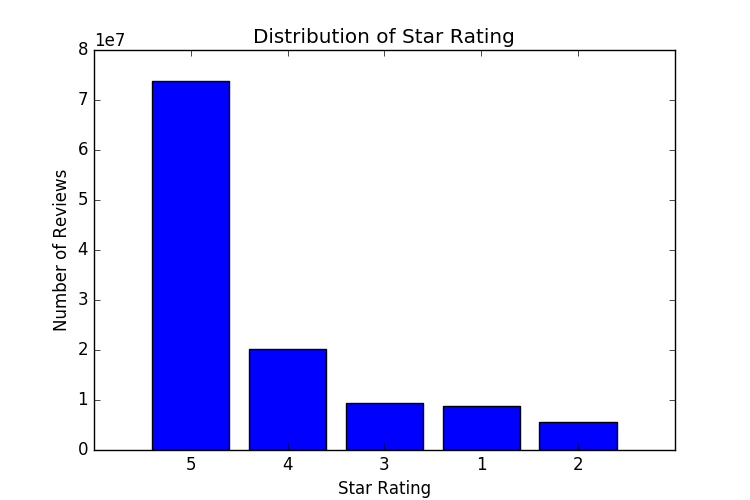

In [20]:
fig = plt.figure(figsize=(7.5, 5))
locations = [1, 2, 3, 4, 5]
heights = rating_df['count']
labels = rating_df['star_rating']
plt.bar(locations, heights, tick_label=labels, align='center')
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Star Rating")
display(fig)

<a id='rpc'></a>
### Number of Reviews for Different Product Categories

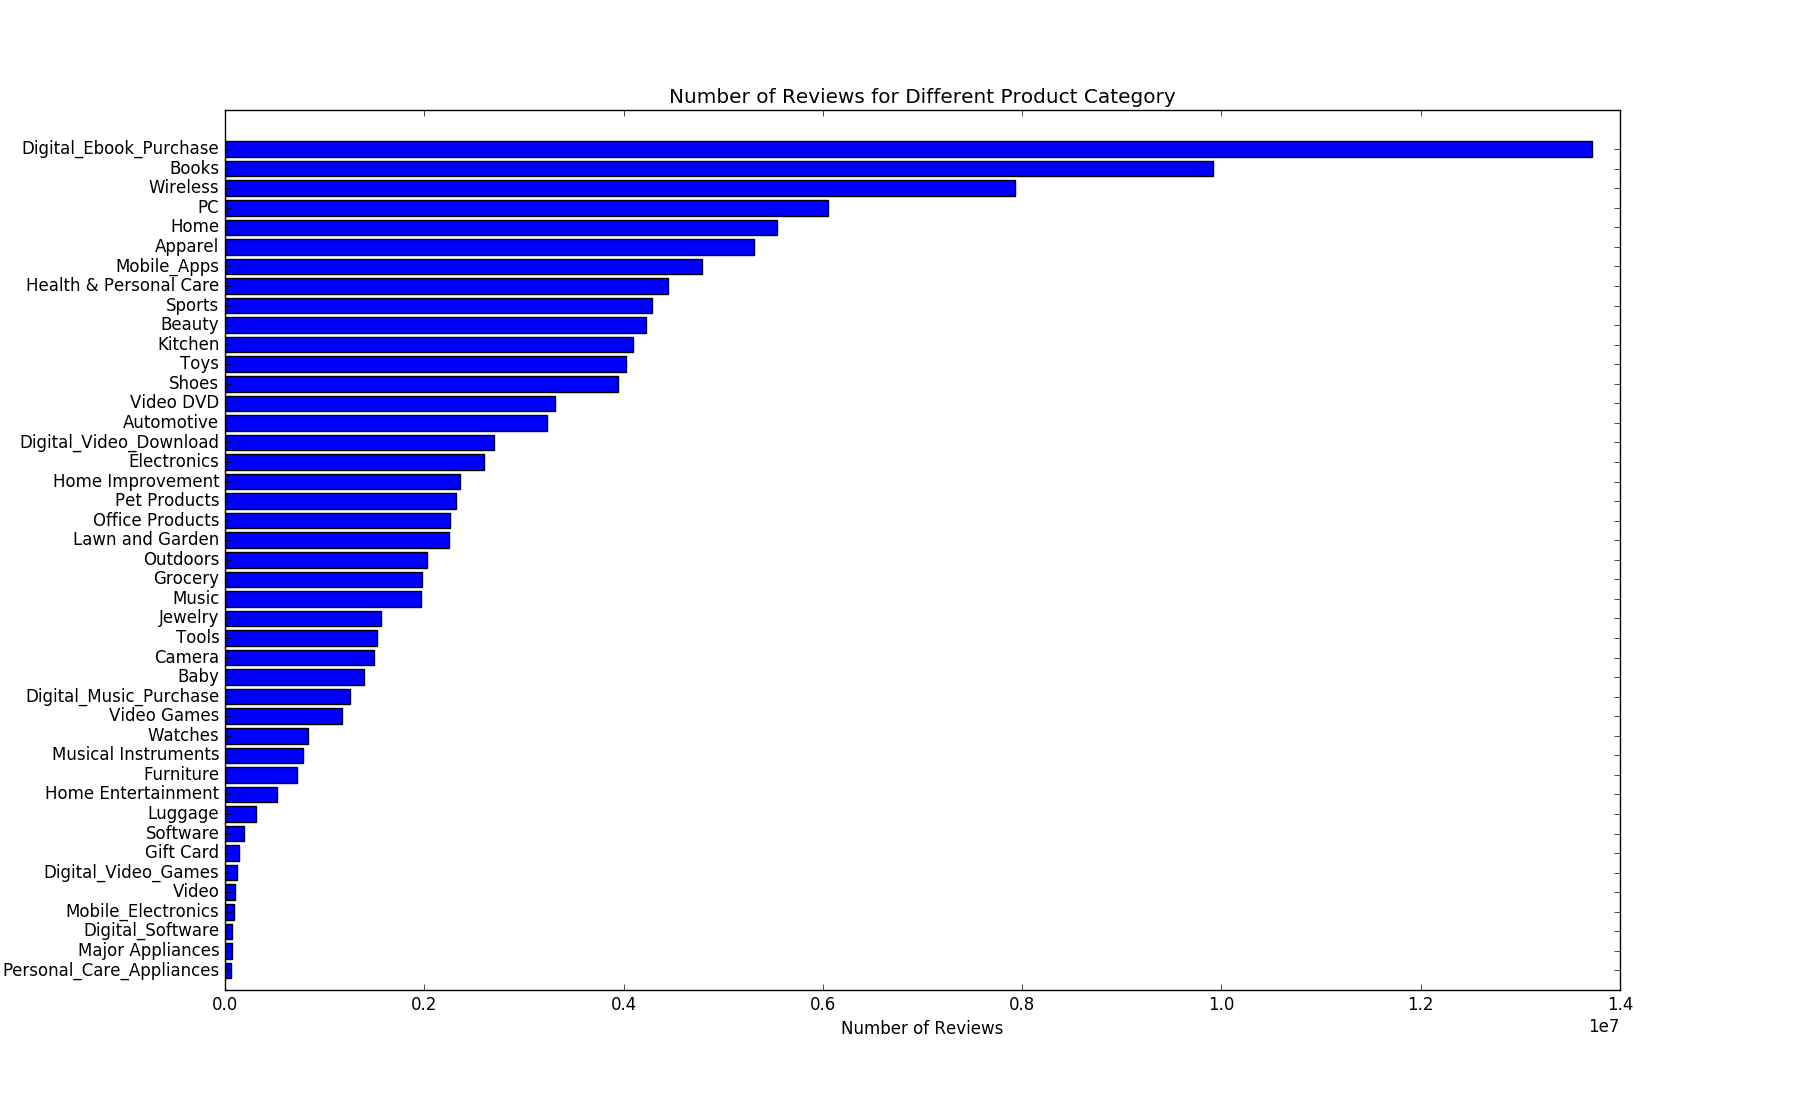

In [22]:
review_count_prodcut_category = verified_review_df.groupBy('product_category').count().toPandas().sort_values('count', ascending=True)
fig = plt.figure(figsize=(18, 11))
locations = list(range(1, 44))
heights = review_count_prodcut_category['count']
labels = review_count_prodcut_category['product_category']
plt.barh(locations, heights, tick_label=labels, align='center')
plt.xlabel("Number of Reviews")
plt.title("Number of Reviews for Different Product Category")
display(fig)

<a id='roy'></a>
### Number of Reviews over Years

In [24]:
import pyspark.sql.functions as f
verified_review_df = verified_review_df.withColumn('review_year', f.year(verified_review_df['review_date']))

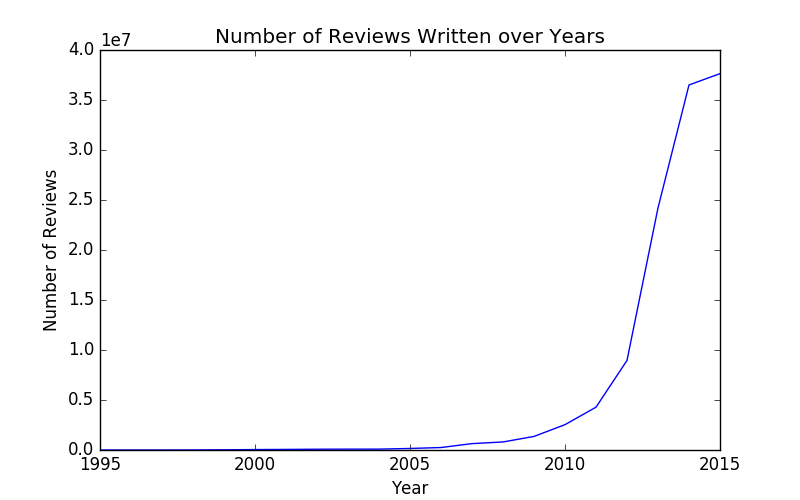

In [25]:
review_count_year = verified_review_df.groupBy('review_year').count().toPandas().sort_values('review_year')
fig = plt.figure(figsize=(8, 5))
plt.plot(review_count_year['review_year'], review_count_year['count'])
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.title("Number of Reviews Written over Years")
display(fig)

<a id='arpc'></a>
### Average Rating of Different Product Categories

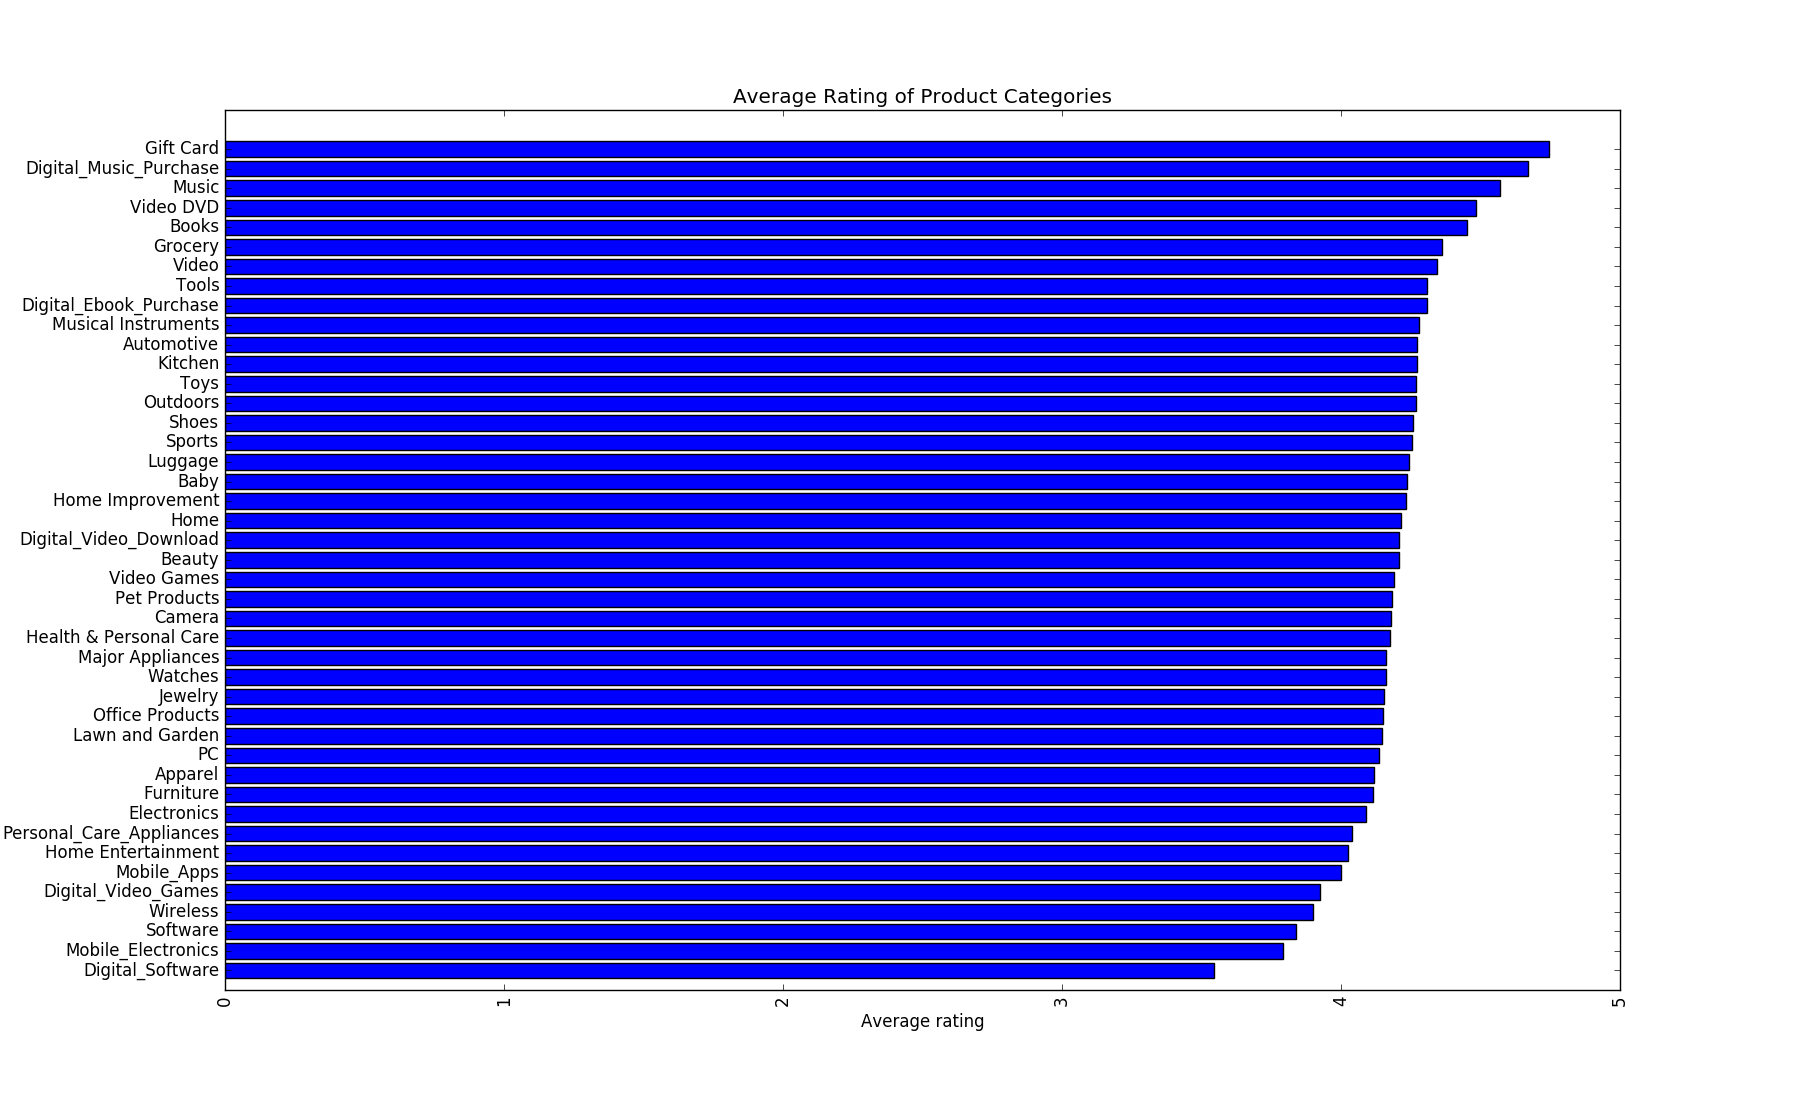

In [27]:
rating_prodcut_category = verified_review_df.groupBy('product_category').agg({"star_rating": "avg"}).toPandas().sort_values('avg(star_rating)', ascending=True)
fig = plt.figure(figsize=(18, 11))
locations = list(range(1, 44))
heights = rating_prodcut_category['avg(star_rating)']
labels = rating_prodcut_category['product_category']
plt.barh(locations, heights, tick_label=labels, align='center')
plt.xticks(rotation='vertical')
plt.xlabel("Average rating")
plt.title("Average Rating of Product Categories")
display(fig)

<a id='ary'></a>
### Average Rating over Years

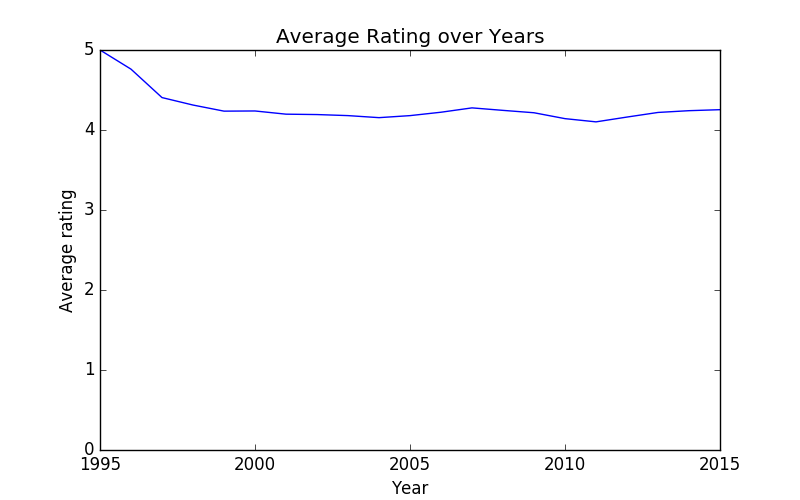

In [29]:
avg_rating_year = verified_review_df.groupBy('review_year').agg({"star_rating": "avg"}).toPandas().sort_values('review_year')
fig = plt.figure(figsize=(8, 5))
plt.plot(avg_rating_year['review_year'], avg_rating_year['avg(star_rating)'])
plt.xlabel("Year")
plt.ylabel("Average rating")
plt.title("Average Rating over Years")
plt.ylim(0,5)
display(fig)

<a id='pmr'></a>
### Top 10 Products with Most Reviews

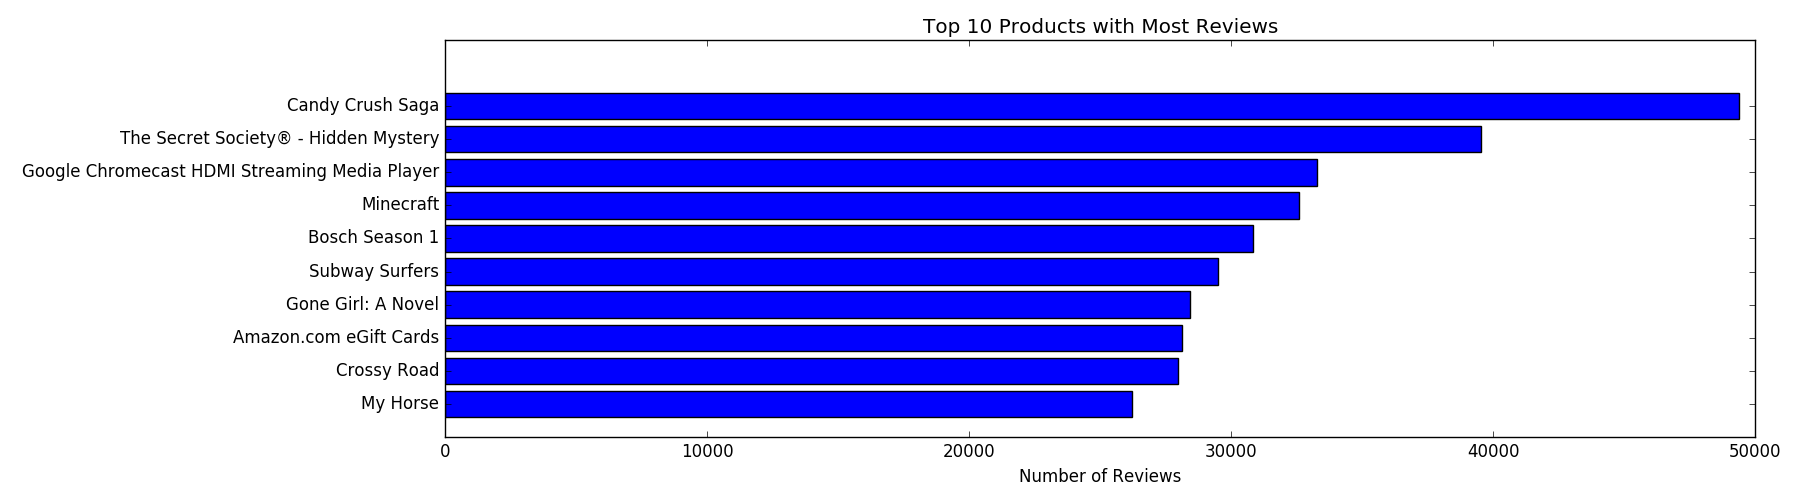

In [31]:
product_title_review_df = verified_review_df.groupBy('product_id', 'product_title').count().toPandas().sort_values('count', ascending=False)[:10][::-1]
fig = plt.figure(figsize=(18, 5))
locations = list(range(1, 11))
heights = product_title_review_df['count']
labels = product_title_review_df['product_title']
plt.barh(locations, heights, tick_label=labels, align='center')
plt.xlabel("Number of Reviews")
plt.title("Top 10 Products with Most Reviews")
plt.tight_layout()
display(fig)

<a id='tpr'></a>
### Top 10 Most Prolific Reviewers
This is in terms of number of reviews written by a customer.

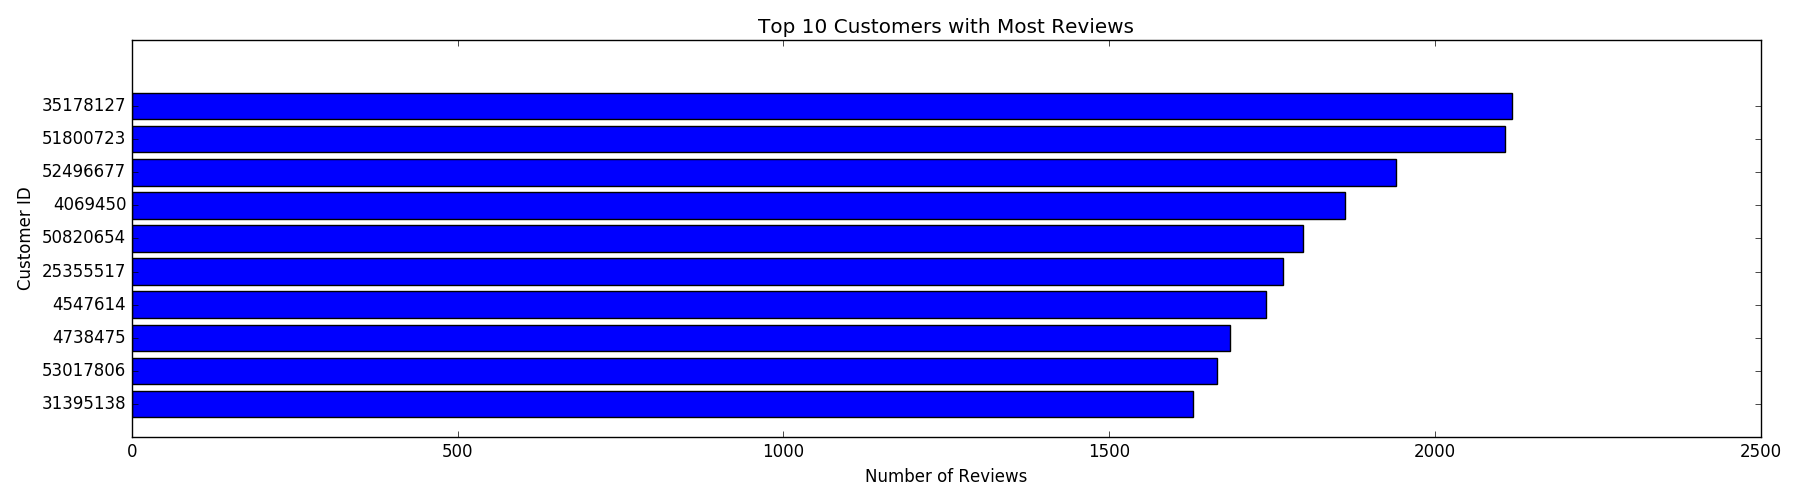

In [33]:
customer_review_df = verified_review_df.groupBy('customer_id').count().toPandas().sort_values('count', ascending=False)[:10][::-1]
fig = plt.figure(figsize=(18, 5))
locations = list(range(1, 11))
heights = customer_review_df['count']
labels = customer_review_df['customer_id']
plt.barh(locations, heights, tick_label=labels, align='center')
plt.xlabel("Number of Reviews")
plt.ylabel("Customer ID")
plt.title("Top 10 Customers with Most Reviews")
plt.tight_layout()
display(fig)

<a id='he'></a>
## Helpfulness Exploration

<a id='dtv'></a>
### Distribution of Total Votes

In [36]:
verified_review_df.groupby("total_votes").count().toPandas().sort_values('total_votes')

,total_votes,count
2306,0,73376644
527,1,20287860
2114,2,8447332
617,3,4315806
1237,4,2624397
793,5,1715230
595,6,1190240
1311,7,883105
1252,8,672502
1078,9,524711


<a id='tht'></a>
### Top 5 Reviews with Highest Total Votes

In [38]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
verified_review_df.sort("total_votes", ascending=False).select('review_body', 'star_rating', 'total_votes', 'helpful_votes').limit(5).toPandas()

review_body 
 star_rating 
 total_votes 
 helpful_votes 
 
 
 
 
 0 
 This is less a \\"pros and cons\\" review than a hopefully useful commentary about the Kindle compared with other eReaders and what it means for the eBook industry. (I believe that everything has changed with the Kindle's creation.)<br /><br />For many years I have been an avid reader of eBooks using almost every eReading device on the market. So as an early-adopter of techie gadgets I had been anxiously awaiting Amazon's Kindle since its first rumors. So I immediately purchased it both out of curiosity and hoping for a better \\"next generation\\" eBook solution. In case you're wondering whether I'm \\"that\\" Steve Gibson, I probably am -- I'm the guy who gets Google's first three or four links when Googling my name.<br /><br />I was driven to write this review because it is somewhat distressing and, it seems to me, a bit unfair for the Kindle's average review rating to be dragged so far down by Kindle NON-OWNERS who, judging from their comments, seem to be quite annoyed by all of the positive comments about a device that's expensive, monochrome, not a general purpose media player, unable to leap tall buildings, or in some way less than they were expecting, wanting, or hoping. In contrast to non-owners, the people who actually HAVE Kindle's appear to universally love it, though with very valid caveats. I think of this as \\"The TiVo Effect\\" since, for the right sort of user, the Kindle will be life-changing ... but it certainly won't be that for everyone. Although it took me a few days to get completely comfortable with it, I am now hooked.<br /><br />So, for what it's worth, if this posting is discovered by any truly interested pre-purchasers, I hope that the following commentary might place the Kindle in \\"perspective\\" and be of some value to you. (And if it is, I hope you'll click the button at the bottom to indicate that, so that this review might be found by more potential buyers ... Thank you!)<br /><br />I have read many novel-length books on my various Palm's, I owned the original Rocket eBook, and I own both generations of Sony's eInk readers, the PRS-500 and PRS-505. So my clear bias is of someone who enjoys technology for its own sake and who loves the idea of reading books on a \\"device.\\"<br /><br />Amazon's first-generation Kindle arguably has a few warts (see below). So depending upon your needs, budget, willingness to purchase a \\"first-generation\\" gizmo that you might regret purchasing and want to replace a year from now, and so forth, you might well decide to wait for the next generation Kindle that will doubtless be even better. But whether you choose to jump aboard now or later, Amazon's entry into the eBook market is a BIG deal -- it forever changes the game. I think there is no doubt that for the first time ever, a substantial number of people who were never captivated by ANY previous eBook system will find themselves reading and enjoying textual content on Kindle's eInk screen.<br /><br />The weird initial love/hate reaction to the Kindle is being compared with Apple's iPod, which was also initially met with striking polarization. We all know how that turned out. :) Although the iPod was far from being the first portable MP3 player, and critics called it a copycat, it was the first portable music player to go mainstream, and it changed the world. I believe that, similarly, the large and tightly interacting collection of Kindle features, that go far beyond those of any other previous eBook attempt, will cause the Kindle to be the first eBook to succeed. By connecting their massive book library, as well as newspapers, magazines, blogs and the Web -- wirelessly -- to a long-battery-life chunk of consumer plastic, Amazon has kicked eBooks into the mainstream.<br /><br />Is the Kindle perfect? Not yet. Is it expensive? Yep. Does it feel like a first-generation product? Absolutely. Will I purchase the next Kindle too? Please let 

<a id='thh'></a>
### Top 5 Reviews with Highest Helpful Votes

In [40]:
verified_review_df.sort("helpful_votes", ascending=False).select('review_body', 'star_rating', 'total_votes', 'helpful_votes').limit(5).toPandas()

review_body 
 star_rating 
 total_votes 
 helpful_votes 
 
 
 
 
 0 
 This is less a \\"pros and cons\\" review than a hopefully useful commentary about the Kindle compared with other eReaders and what it means for the eBook industry. (I believe that everything has changed with the Kindle's creation.)<br /><br />For many years I have been an avid reader of eBooks using almost every eReading device on the market. So as an early-adopter of techie gadgets I had been anxiously awaiting Amazon's Kindle since its first rumors. So I immediately purchased it both out of curiosity and hoping for a better \\"next generation\\" eBook solution. In case you're wondering whether I'm \\"that\\" Steve Gibson, I probably am -- I'm the guy who gets Google's first three or four links when Googling my name.<br /><br />I was driven to write this review because it is somewhat distressing and, it seems to me, a bit unfair for the Kindle's average review rating to be dragged so far down by Kindle NON-OWNERS who, judging from their comments, seem to be quite annoyed by all of the positive comments about a device that's expensive, monochrome, not a general purpose media player, unable to leap tall buildings, or in some way less than they were expecting, wanting, or hoping. In contrast to non-owners, the people who actually HAVE Kindle's appear to universally love it, though with very valid caveats. I think of this as \\"The TiVo Effect\\" since, for the right sort of user, the Kindle will be life-changing ... but it certainly won't be that for everyone. Although it took me a few days to get completely comfortable with it, I am now hooked.<br /><br />So, for what it's worth, if this posting is discovered by any truly interested pre-purchasers, I hope that the following commentary might place the Kindle in \\"perspective\\" and be of some value to you. (And if it is, I hope you'll click the button at the bottom to indicate that, so that this review might be found by more potential buyers ... Thank you!)<br /><br />I have read many novel-length books on my various Palm's, I owned the original Rocket eBook, and I own both generations of Sony's eInk readers, the PRS-500 and PRS-505. So my clear bias is of someone who enjoys technology for its own sake and who loves the idea of reading books on a \\"device.\\"<br /><br />Amazon's first-generation Kindle arguably has a few warts (see below). So depending upon your needs, budget, willingness to purchase a \\"first-generation\\" gizmo that you might regret purchasing and want to replace a year from now, and so forth, you might well decide to wait for the next generation Kindle that will doubtless be even better. But whether you choose to jump aboard now or later, Amazon's entry into the eBook market is a BIG deal -- it forever changes the game. I think there is no doubt that for the first time ever, a substantial number of people who were never captivated by ANY previous eBook system will find themselves reading and enjoying textual content on Kindle's eInk screen.<br /><br />The weird initial love/hate reaction to the Kindle is being compared with Apple's iPod, which was also initially met with striking polarization. We all know how that turned out. :) Although the iPod was far from being the first portable MP3 player, and critics called it a copycat, it was the first portable music player to go mainstream, and it changed the world. I believe that, similarly, the large and tightly interacting collection of Kindle features, that go far beyond those of any other previous eBook attempt, will cause the Kindle to be the first eBook to succeed. By connecting their massive book library, as well as newspapers, magazines, blogs and the Web -- wirelessly -- to a long-battery-life chunk of consumer plastic, Amazon has kicked eBooks into the mainstream.<br /><br />Is the Kindle perfect? Not yet. Is it expensive? Yep. Does it feel like a first-generation product? Absolutely. Will I purchase the next Kindle too? Please let 

<a id='thv'></a>
### Top 10 Reviewers with Most Helpful Votes

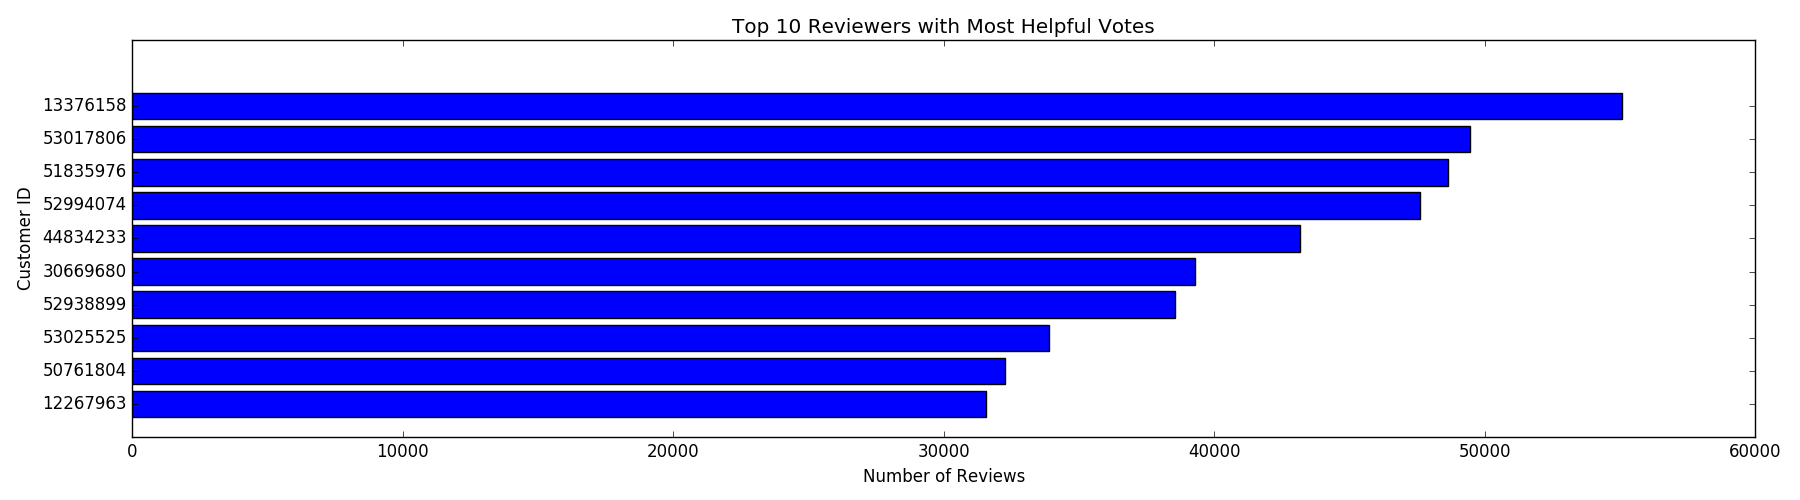

In [42]:
customer_helpful_df = verified_review_df.groupBy('customer_id').agg({"helpful_votes": "sum"}).toPandas().sort_values('sum(helpful_votes)', ascending=False)[:10][::-1]
fig = plt.figure(figsize=(18, 5))
locations = list(range(1, 11))
heights = customer_helpful_df['sum(helpful_votes)']
labels = customer_helpful_df['customer_id']
plt.barh(locations, heights, tick_label=labels, align='center')
plt.xlabel("Number of Reviews")
plt.ylabel("Customer ID")
plt.title("Top 10 Reviewers with Most Helpful Votes")
plt.tight_layout()
display(fig)

#### Helpfulness index
Absolute number of helpful votes is not suitable for comparison because of varying number of total votes among different reviews. For instance, a review with 15 helpful votes out of 10,000 total votes must be less helpful than a review with 10 helpful votes out of 11 total votes. To deal with this issue, a new helpful_index has been created by dividing helpful_votes by total_votes.

#### Subset Review with More Than Five Total Votes

Another issue is that total and helpful votes for most of the reveiws are 0. Furthermore, very low total votes may bias the analysis. For instance if there is only one total vote and if it is voted as helpful, it works out to a helpful_index of 1, which may or may not be reliable. To circumvent this problem, only reviews with more than 5 total votes are taken into consideration for this analysis

In [46]:
# Subset only reviews with more than 5 total votes
helpful_subset_df = verified_review_df.filter(verified_review_df["total_votes"] > 5)

In [47]:
helpful_subset_df.limit(5).toPandas()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,36479105,R3J6THSJ6OO5H6,0552170534,969778319,Serve To Win: The 14-Day Gluten-free Plan for ...,Books,2,1,7,N,Y,Not worth the paper it was printed on,A lot easier to just Google ELISA test or find...,2015-08-31
1,US,16747249,R2TRQAQL0R9QJX,0300181051,441242249,The President and the Apprentice: Eisenhower a...,Books,3,0,14,N,Y,Three Stars,Was a gift who said it was<br />ok,2015-08-31
2,US,16690418,R88WCYTAGSZ65,3954510529,270072972,111 Places in New York That You Must Not Miss,Books,5,5,7,N,Y,An outstanding experience with delightful secr...,Ms. Elikann has created an original work that ...,2015-08-31
3,US,25474691,R2DRRC1HRH7UR5,0984353356,784406414,A Village to Village Guide to Hiking the Camin...,Books,4,7,7,N,Y,The book provided great information. I was pla...,We are planning to do this journey in 2017. T...,2015-08-31
4,US,44335845,R3CDMBI1U1H73M,1626251649,961026318,Natural Relief for Adult ADHD: Complementary S...,Books,5,2,6,N,Y,... Naturaly this is your go to book for infor...,If you can do it Naturaly this is your go to b...,2015-08-31


In [48]:
helpful_subset_df = helpful_subset_df.withColumn('helpful_index', helpful_subset_df.helpful_votes/helpful_subset_df.total_votes)

<a id='atsr'></a>
### Average Total Votes Vs Star Rating

In [50]:
rating_avg_total_df = helpful_subset_df.groupBy('star_rating').agg({"total_votes": "avg"}).toPandas().sort_values('avg(total_votes)', ascending=False)
fig = plt.figure(figsize=(6, 5))
locations = [1, 2, 3, 4, 5]
heights = rating_avg_total_df['avg(total_votes)']
labels = rating_avg_total_df['star_rating']
plt.bar(locations, heights, tick_label=labels, align='center')
plt.xlabel("Star Rating")
plt.ylabel("Average Total votes")
plt.title("Average Total Votes Vs Star Rating")
display(fig)

<a id='ahsr'></a>
### Average Helpfull Votes Vs Star Rating

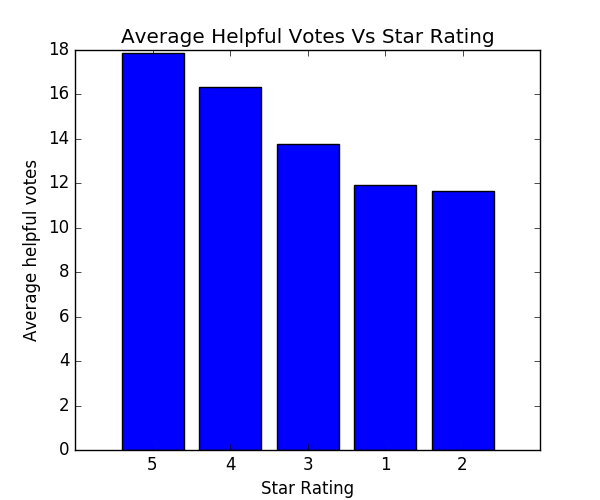

In [52]:
rating_avg_helpful_df = helpful_subset_df.groupBy('star_rating').agg({"helpful_votes": "avg"}).toPandas().sort_values('avg(helpful_votes)', ascending=False)
fig = plt.figure(figsize=(6, 5))
locations = [1, 2, 3, 4, 5]
heights = rating_avg_helpful_df['avg(helpful_votes)']
labels = rating_avg_helpful_df['star_rating']
plt.bar(locations, heights, tick_label=labels, align='center')
plt.xlabel("Star Rating")
plt.ylabel("Average helpful votes")
plt.title("Average Helpful Votes Vs Star Rating")
display(fig)

<a id='ahi'></a>
### Average helpful_index Vs Star Rating

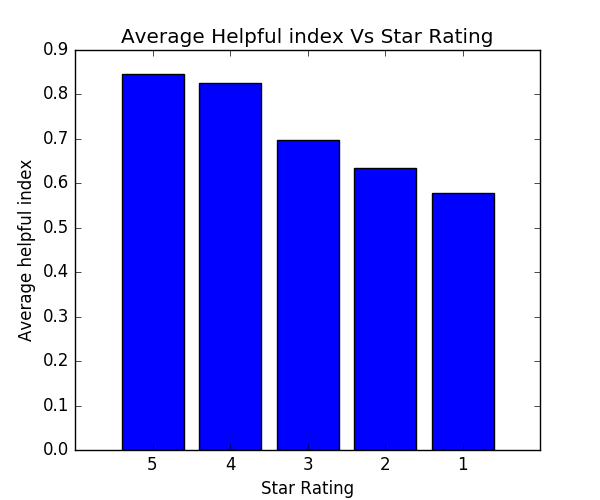

In [54]:
rating_avg_help_index_df = helpful_subset_df.groupBy('star_rating').agg({"helpful_index": "avg"}).toPandas().sort_values('avg(helpful_index)', ascending=False)
fig = plt.figure(figsize=(6, 5))
locations = [1, 2, 3, 4, 5]
heights = rating_avg_help_index_df['avg(helpful_index)']
labels = rating_avg_help_index_df['star_rating']
plt.bar(locations, heights, tick_label=labels, align='center')
plt.xlabel("Star Rating")
plt.ylabel("Average helpful index")
plt.title("Average Helpful index Vs Star Rating")
display(fig)

<a id='atvy'></a>
### Average Total Votes over Years

In [56]:
# Delete
import pyspark.sql.functions as f
helpful_subset_df = helpful_subset_df.withColumn('review_year', f.year(verified_review_df['review_date']))

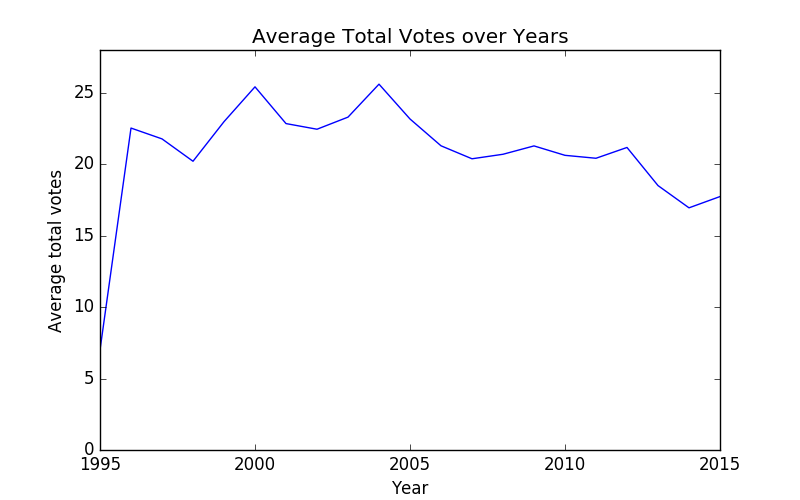

In [57]:
avg_total_vote_year = helpful_subset_df.groupBy('review_year').agg({"total_votes": "avg"}).toPandas().sort_values('review_year')
fig = plt.figure(figsize=(8, 5))
plt.plot(avg_total_vote_year['review_year'], avg_total_vote_year['avg(total_votes)'])
plt.xlabel("Year")
plt.ylabel("Average total votes")
plt.title("Average Total Votes over Years")
plt.ylim(0,28)
display(fig)

<a id='ahvy'></a>
### Average Helpful Votes over Years

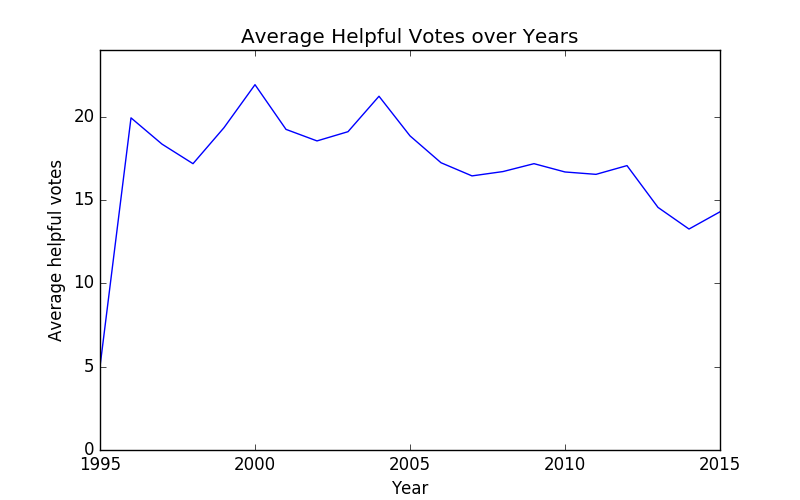

In [59]:
avg_help_votes_year = helpful_subset_df.groupBy('review_year').agg({"helpful_votes": "avg"}).toPandas().sort_values('review_year')
fig = plt.figure(figsize=(8, 5))
plt.plot(avg_help_votes_year['review_year'], avg_help_votes_year['avg(helpful_votes)'])
plt.xlabel("Year")
plt.ylabel("Average helpful votes")
plt.title("Average Helpful Votes over Years")
plt.ylim(0,24)
display(fig)

<a id='ahiy'></a>
### Average Helpful Index over Years

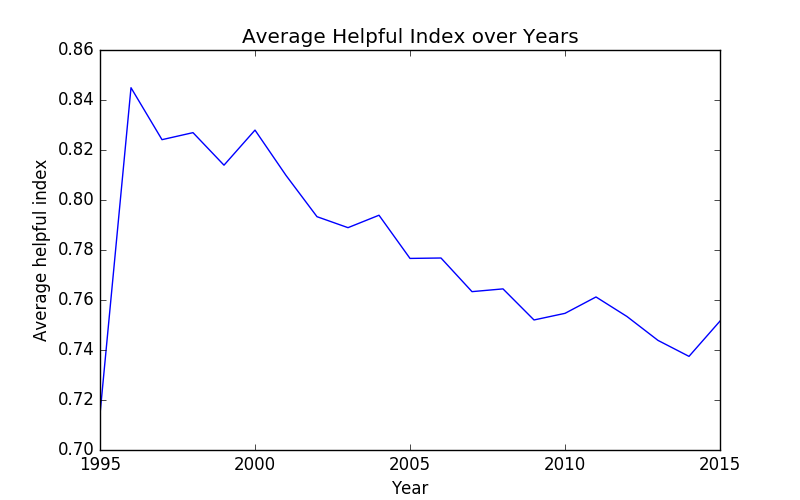

In [61]:
avg_help_index_year = helpful_subset_df.groupBy('review_year').agg({"helpful_index": "avg"}).toPandas().sort_values('review_year')
fig = plt.figure(figsize=(8, 5))
plt.plot(avg_help_index_year['review_year'], avg_help_index_year['avg(helpful_index)'])
plt.xlabel("Year")
plt.ylabel("Average helpful index")
plt.title("Average Helpful Index over Years")
plt.ylim()
display(fig)

<a id='eda'></a>

## Findings of EDA
1.	More than 62% of the reviews on Amazon has a rating of 5. Only 12% of the reviews has a star rating of 1 or 2 ([see chart](#rd)).
2.	The product category *Digital E-books* has the highest number of reviews ([see chart](#rpc)).
3.	There is a steep increase in number of reviews from the year 2010. This may be due to increase in smart phone usage and social media growth ([see chart](#roy)).
4.	The product category *Gift Card* has the highest rating ([see chart](#arpc)). This may be due to the fact that there is less chances that something goes wrong with gift cards.
5.	Average rating stays almost the same (~4.2) over years ([see chart](#ary)).
6.	The product with the most reviews is *Candy Crush Saga* ([see chart](#pmr)).
7.	It is interesting to see a customer with ID 35178127 has written more than 2000 reviews ([see chart](#tpr)).
8.	There is a review that has got as many as 48,362 total votes out of which 47,524 were voted as helpful ([see chart](#thh)). This is a review about Kindle, which seems to be written right after the launch of this product.
9.	The reviews written by a customer with ID 13376158 has received more than 50,000 helpful votes ([see chart](#thv)).
10.	Reviews with star rating of 5 are perceived to be more helpful than reviews with other ratings; it has the highest average helpful votes as well as the highest helpful index ([see chart](#ahsr)).
11.	The quality of Amazon reviews seems to be decreasing over time as indicated by decreasing trend in helpful index ([see chart](#ahiy)). Ease with which you can write a review over past few years seems to have affected the quality of reviews.